In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from specutils import Spectrum1D
import glob
from matplotlib.colors import Normalize, LinearSegmentedColormap


In [55]:
#Glob all the spectra files
spectra_dir="/home/kevin/aufklarung_astro_station/sdss_spectra/"
spectra_paths=glob.glob(spectra_dir+"*.fits")

In [56]:
#Open all the spectra files and store them in a list
spectra_list=[]
for spec_files in spectra_paths:
    with fits.open(spec_files) as f:
        spec=f[1].data
        header=f[0].header
    spectra_list.append(spec)

#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in spectra_list:
    print(i.shape)
    spec_shape_list.append(i.shape)

spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

(3822,)
(3822,)
(3828,)
(3846,)
(3769,)


In [ ]:
#3.582
#3.957

In [137]:
#Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda
#to last lambda, as in some spectra the measurements start from different first to different last lambda
spectra_filtered_list=[]
for i in spectra_list:
    spec=i
    #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    spectra_filtered_list.append(filtered_data)
#And here we have a np array containing individual spectras
spectra_filtered_list=np.array(spectra_filtered_list)
spectra_filtered_list.shape

(5, 3751)

In [140]:
spectra_filtered_list['loglam']

array([[3.582 , 3.5821, 3.5822, ..., 3.9568, 3.9569, 3.957 ],
       [3.582 , 3.5821, 3.5822, ..., 3.9568, 3.9569, 3.957 ],
       [3.582 , 3.5821, 3.5822, ..., 3.9568, 3.9569, 3.957 ],
       [3.582 , 3.5821, 3.5822, ..., 3.9568, 3.9569, 3.957 ],
       [3.582 , 3.5821, 3.5822, ..., 3.9568, 3.9569, 3.957 ]],
      dtype=float32)

In [154]:
#convert the log lam and flux to proper units 
lamb=10**spectra_filtered_list['loglam'] * u.AA
flux = spectra_filtered_list['flux'] * 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
#put the lamb and flux to the 1d specutils object
spectra_converted_flux_lamb_object_list=[]
#performing loop to make a specutils object list
for i,j in zip(lamb, flux):
    spectrum=Spectrum1D(spectral_axis=i, flux=j)
    spectra_converted_flux_lamb_object_list.append(spectrum)

spectra_converted_flux_lamb_object_list=np.array(spectra_converted_flux_lamb)  


In [156]:
#Here extract array of fluxes and lambdas of individual spectra before adding oh noise
spectra_object_lamb=[]
spectra_object_flux=[]
for i in spectra_converted_flux_lamb_object_list:
    spectra_object_flux.append(np.array(i.flux))
    spectra_object_lamb.append(np.array(i.spectral_axis))
    

In [164]:
#Generate dummy OH lines which are bright
oh_lines_wavelenght=np.array([5500, 5890, 6300, 6364, 6863, 7276 , 7500, 7800, 
                             7900, 8000, 8100, 8200, 8300, 8400])
oh_flux= np.array([100*10**-16, 100*10**-16, 100*10**-16, 100*10**-16, 100*10**-16, 100*10**-16,
                100*10**-16, 100*10**-16, 100*10**-16, 100*10**-16, 100*10**-16, 100*10**-16,
                   100*10**-16, 100*10**-16  ])

#Define a gaussian profile for each line
def gaussian_line(spec_wavelenght, oh_intensity, oh_center, width=2.0):
    return oh_intensity*np.exp(-0.5*((spec_wavelenght - oh_center)/width)**2)

In [173]:
#Loop over all oh lines
for center, intensity in zip(oh_lines_wavelenght, oh_flux):
    #Loop over all the individual spectra
    for i in range(spectra_converted_flux_lamb_object_list.shape[0]):
        #spectra_converted_flux_lamb_object_list.shape[0] this just tells number of spectras to loop over
        #Add OH lines to galaxy spectra
        spectra_object_flux[i]+=gaussian_line(spectra_object_lamb[i], intensity, center)
    

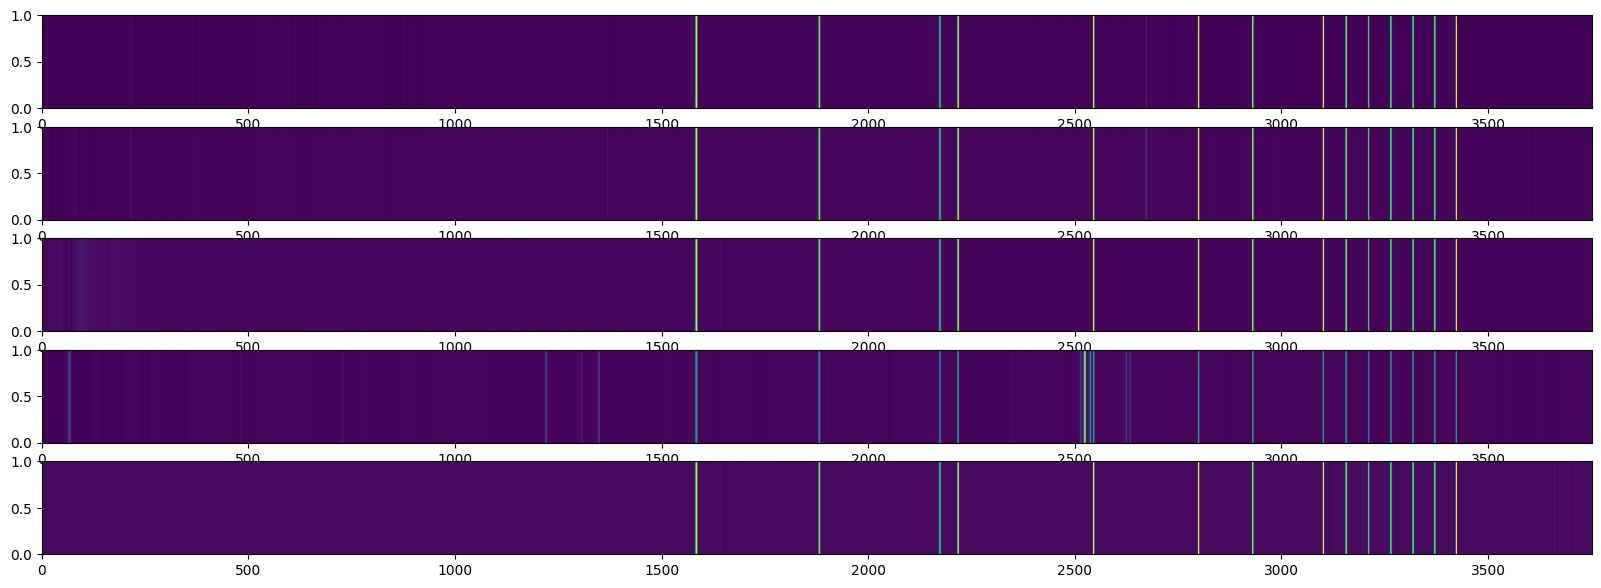

In [188]:
fig,ax=plt.subplots(nrows=5, ncols=1, figsize=(20,7))
ax[0].pcolormesh( spectra_object_flux[0][:,None].T)
ax[1].pcolormesh( spectra_object_flux[1][:,None].T)
ax[2].pcolormesh( spectra_object_flux[2][:,None].T)
ax[3].pcolormesh( spectra_object_flux[3][:,None].T)
ax[4].pcolormesh( spectra_object_flux[4][:,None].T)


In [189]:
#Save the array of oh lines infected spectras to numpy file
np.save('multiple_spectra_with_oh_lines.npy',spectra_object_flux)